<a href="https://colab.research.google.com/github/Dadi-Lakshmi-Harsha/Denoising-image-using-GAN/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 20.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 505kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.63MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.75MB/s]


[Epoch 1/12] D_loss: 0.6861 G_loss: 2.9283 | PSNR: 24.405 SSIM: 0.9503 | elapsed: 0.9m


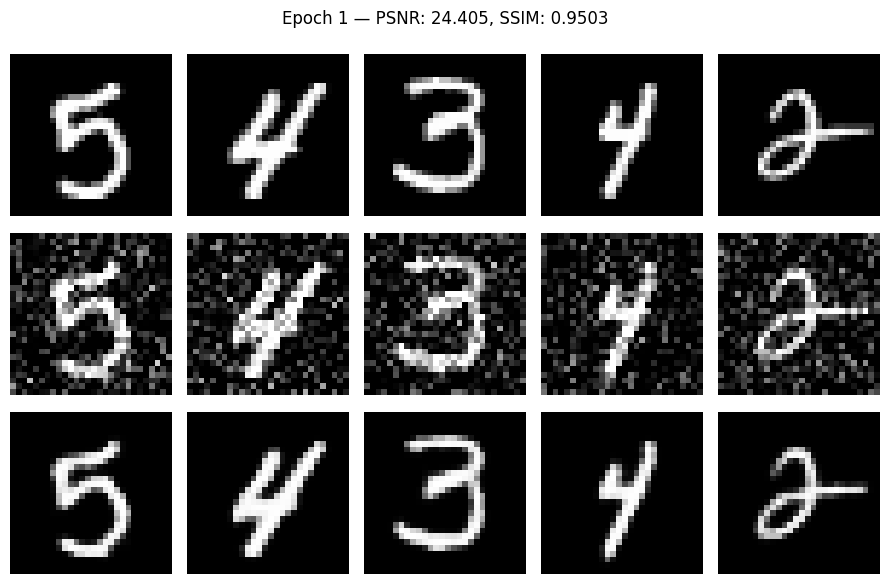

[Epoch 2/12] D_loss: 0.6819 G_loss: 2.5918 | PSNR: 25.195 SSIM: 0.9559 | elapsed: 1.9m


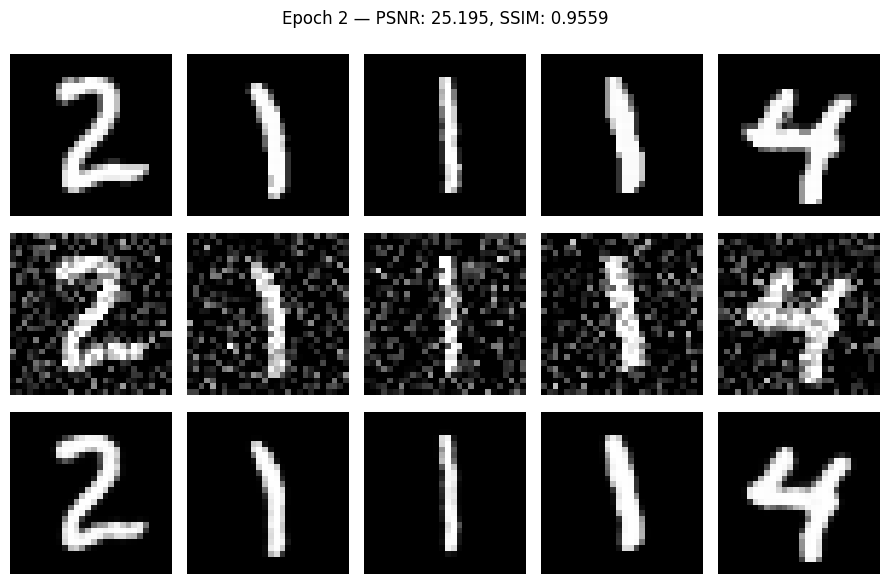

[Epoch 3/12] D_loss: 0.6795 G_loss: 2.5315 | PSNR: 24.762 SSIM: 0.9526 | elapsed: 2.8m


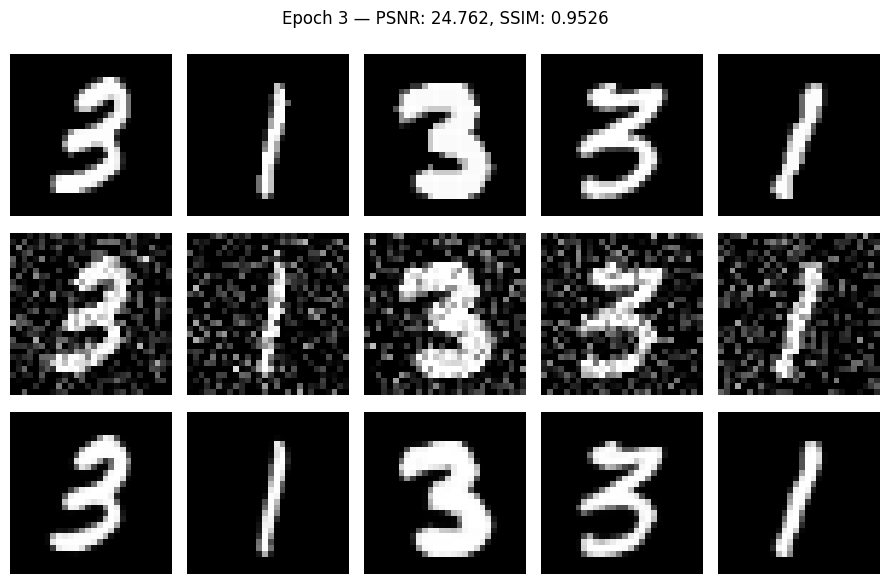

[Epoch 4/12] D_loss: 0.6782 G_loss: 2.5040 | PSNR: 24.806 SSIM: 0.9587 | elapsed: 3.7m


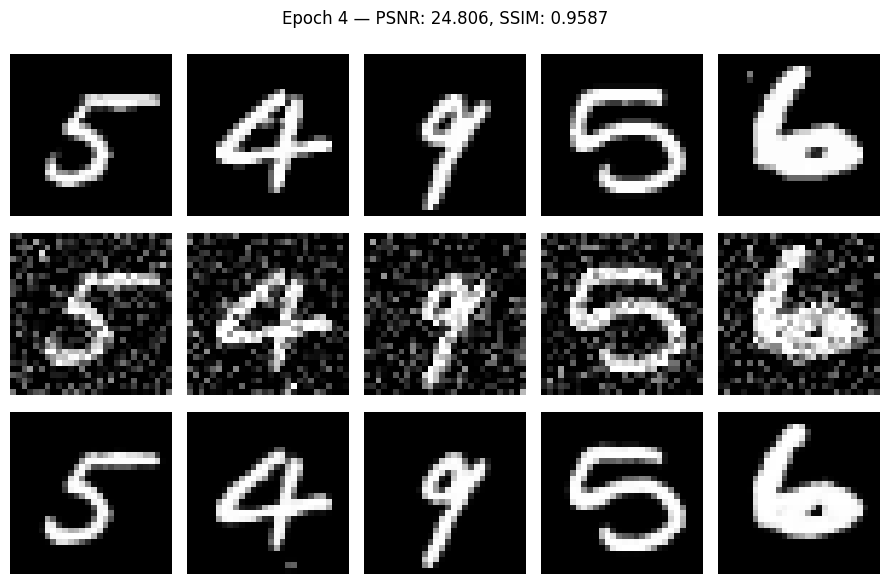

[Epoch 5/12] D_loss: 0.6785 G_loss: 2.4911 | PSNR: 25.125 SSIM: 0.9605 | elapsed: 4.7m


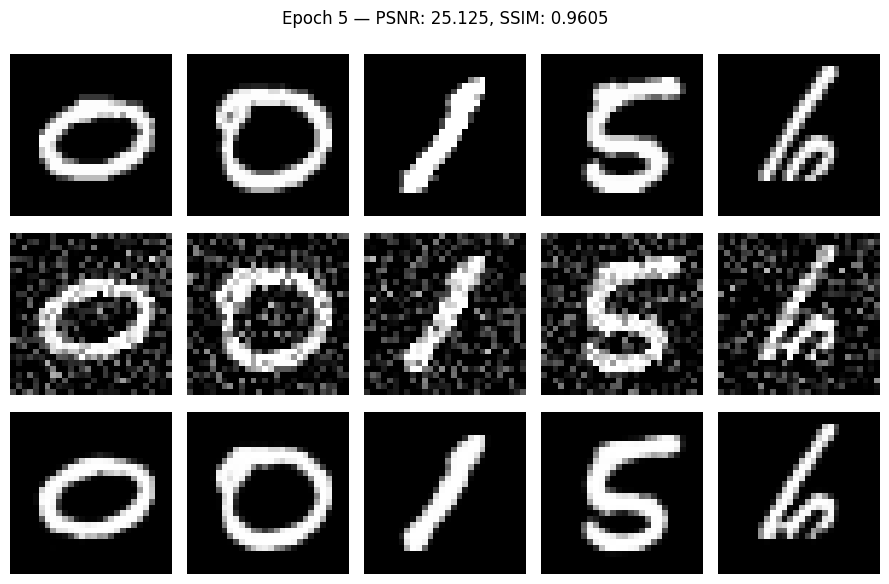

[Epoch 6/12] D_loss: 0.6792 G_loss: 2.4823 | PSNR: 25.210 SSIM: 0.9631 | elapsed: 5.6m


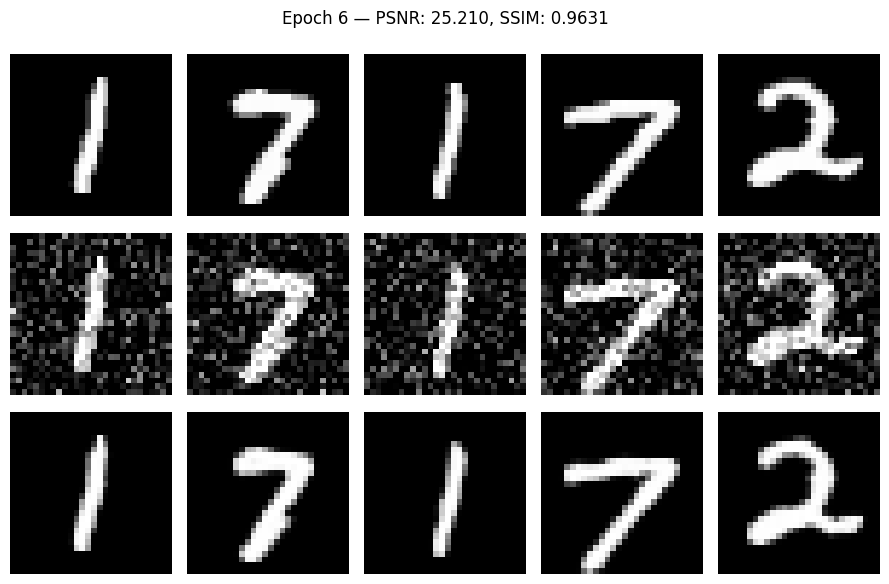

[Epoch 7/12] D_loss: 0.6800 G_loss: 2.4740 | PSNR: 25.186 SSIM: 0.9560 | elapsed: 6.5m


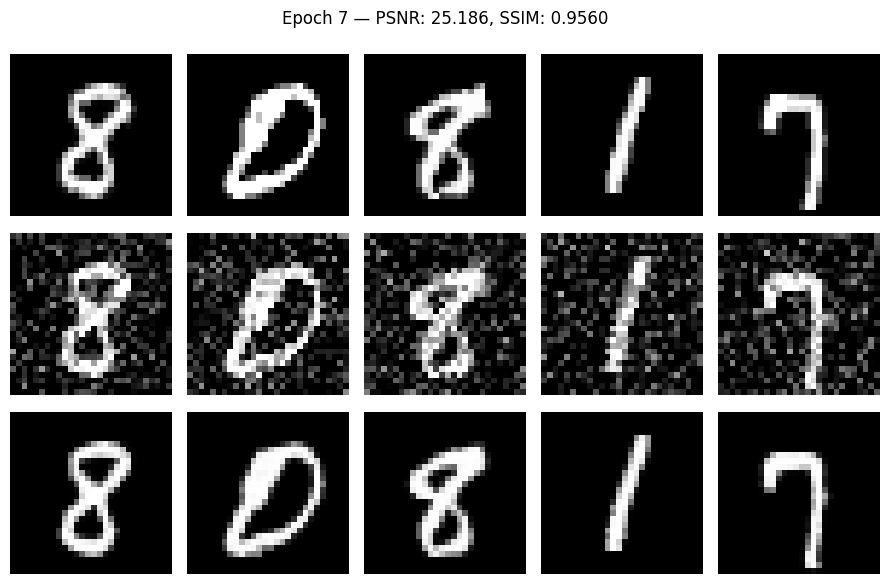

[Epoch 8/12] D_loss: 0.6804 G_loss: 2.4685 | PSNR: 24.912 SSIM: 0.9582 | elapsed: 7.5m


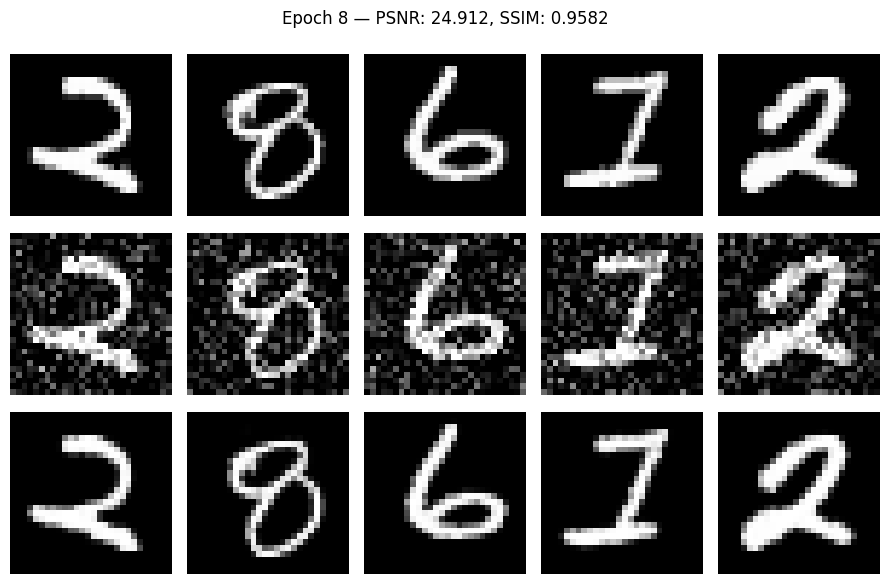

[Epoch 9/12] D_loss: 0.6807 G_loss: 2.4629 | PSNR: 24.754 SSIM: 0.9577 | elapsed: 8.4m


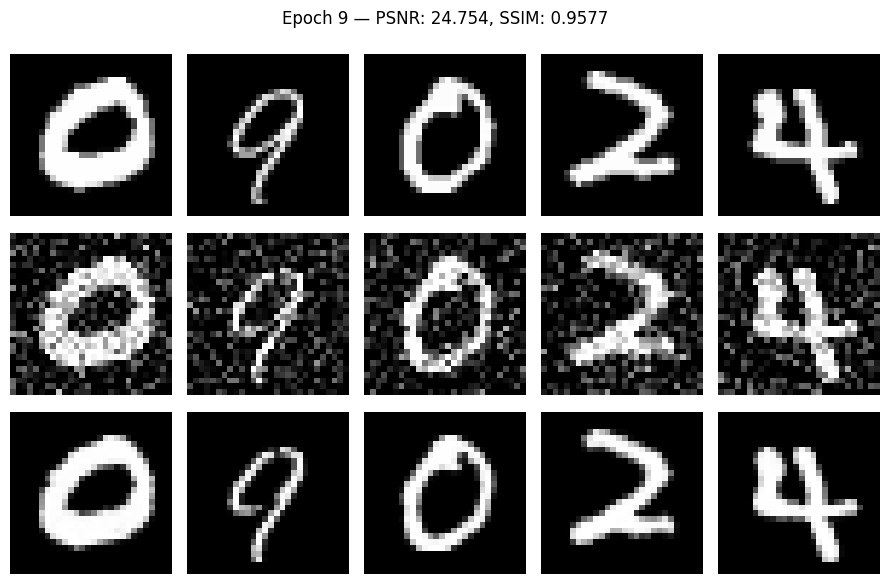

[Epoch 10/12] D_loss: 0.6807 G_loss: 2.4580 | PSNR: 25.131 SSIM: 0.9611 | elapsed: 9.3m


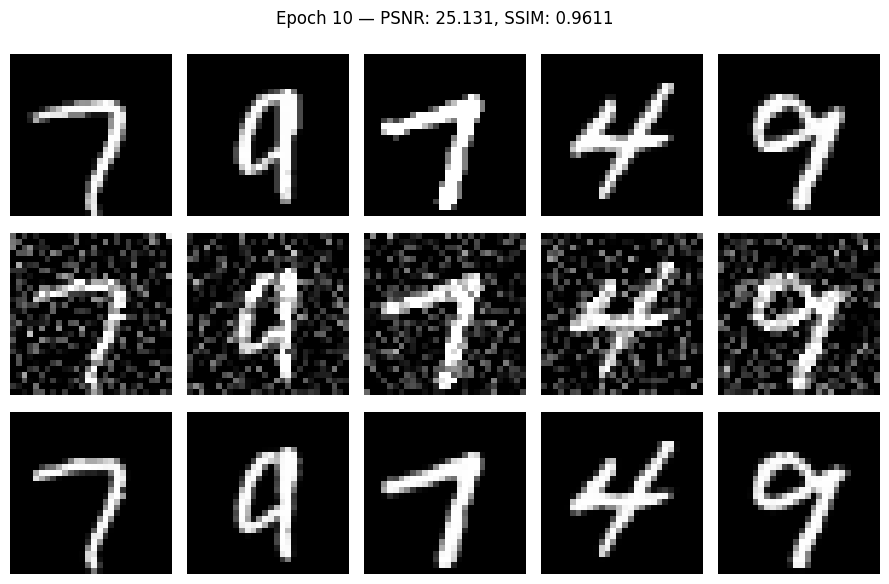

[Epoch 11/12] D_loss: 0.6807 G_loss: 2.4544 | PSNR: 24.939 SSIM: 0.9590 | elapsed: 10.3m


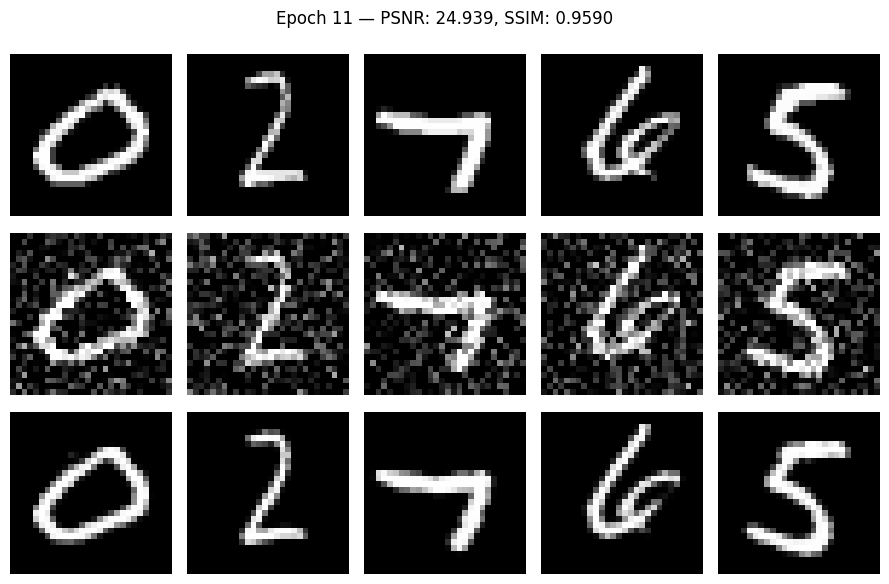

[Epoch 12/12] D_loss: 0.6806 G_loss: 2.4508 | PSNR: 24.658 SSIM: 0.9588 | elapsed: 11.2m


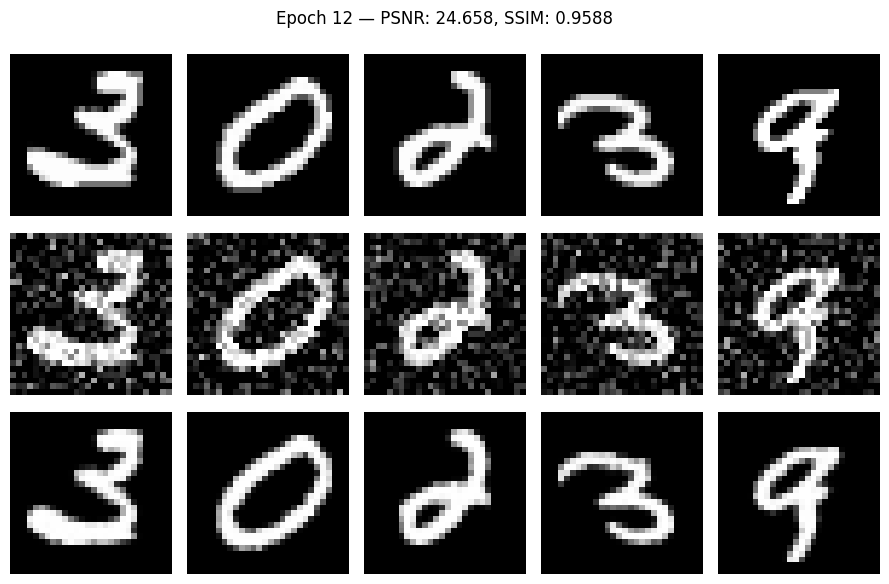

Training finished and models saved.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim
from math import log10
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
def psnr_t(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100.0
    return 20 * torch.log10(1.0 / torch.sqrt(mse)).item()

def denorm(x):
    return (x + 1.0) / 2.0

def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# ---------------------------
# Residual block
# ---------------------------
class ResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
        self.act = nn.ReLU(inplace=True)
    def forward(self, x):
        out = self.act(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return self.act(out + x)

# ---------------------------
# Generator: UNet-ish with residual blocks
# Input: noisy image (B,1,28,28), Output: denoised image in [-1,1]
# ---------------------------
class GeneratorResUNet(nn.Module):
    def __init__(self, in_ch=1, base_ch=64, n_res=2):
        super().__init__()
        # encoder
        self.enc1 = nn.Sequential(nn.Conv2d(in_ch, base_ch, 3, padding=1), nn.ReLU(inplace=True))
        self.enc2 = nn.Sequential(nn.Conv2d(base_ch, base_ch*2, 4, stride=2, padding=1), nn.ReLU(inplace=True))
        self.enc3 = nn.Sequential(nn.Conv2d(base_ch*2, base_ch*4, 4, stride=2, padding=1), nn.ReLU(inplace=True))
        # bottleneck residual blocks
        res_layers = []
        for _ in range(n_res):
            res_layers.append(ResBlock(base_ch*4))
        self.resblocks = nn.Sequential(*res_layers)
        # decoder (upsample)
        self.up2 = nn.ConvTranspose2d(base_ch*4, base_ch*2, 4, stride=2, padding=1)
        self.up1 = nn.ConvTranspose2d(base_ch*2, base_ch, 4, stride=2, padding=1)
        # final conv
        self.final = nn.Sequential(
            nn.Conv2d(base_ch, in_ch, 3, padding=1),
            nn.Tanh())
        # small convs to process skip connections
        self.skip2 = nn.Conv2d(base_ch*2, base_ch*2, 3, padding=1)
        self.skip1 = nn.Conv2d(base_ch, base_ch, 3, padding=1)

    def forward(self, x):
        # x: (B,1,28,28)
        e1 = self.enc1(x)         # (B,64,28,28)
        e2 = self.enc2(e1)        # (B,128,14,14)
        e3 = self.enc3(e2)        # (B,256,7,7)
        r = self.resblocks(e3)    # (B,256,7,7)
        d2 = self.up2(r)          # (B,128,14,14)
        d2 = d2 + self.skip2(e2)  # skip
        d1 = self.up1(d2)         # (B,64,28,28)
        d1 = d1 + self.skip1(e1)  # skip
        out = self.final(d1)      # (B,1,28,28)
        return out

# ---------------------------
# PatchGAN Discriminator
# Input: image 28x28 -> outputs patch realism map (smaller), mean -> score
# ---------------------------
class PatchDiscriminator(nn.Module):
    def __init__(self, in_ch=1, base_ch=64):
        super().__init__()
        # Use spectral norm to stabilize (optional)
        self.net = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(in_ch, base_ch, 4, stride=2, padding=1)), # 14x14
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Conv2d(base_ch, base_ch*2, 4, stride=2, padding=1)), # 7x7
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Conv2d(base_ch*2, base_ch*4, 3, padding=1)), # 7x7
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(base_ch*4, 1, 3, padding=1)  # patch map
        )
    def forward(self, x):
        pmap = self.net(x)
        return pmap.view(pmap.size(0), -1).mean(dim=1, keepdim=True)

# ---------------------------
# Data
# ---------------------------
transform = transforms.Compose([
    transforms.ToTensor(),             # (0,1)
    transforms.Normalize((0.5,), (0.5,))  # -> (-1,1)
])
trainset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
loader = DataLoader(trainset, batch_size=64, shuffle=True, drop_last=True)

# ---------------------------
# Instantiate
# ---------------------------
G = GeneratorResUNet().to(device)
D = PatchDiscriminator().to(device)
G.apply(weights_init)
D.apply(weights_init)

# loss functions & optimizers
adv_loss = nn.BCEWithLogitsLoss()  # use logits in disc output; we'll adapt discriminator to output scalar logits if needed
l1_loss = nn.L1Loss()
optG = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
optD = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

# ---------------------------
# Train parameters
# ---------------------------
n_epochs = 12
lambda_l1 = 50.0      # strong L1 weight usually helps denoising (pix2pix style)
real_label = 0.9      # label smoothing
fake_label = 0.0

start_time = time.time()
for epoch in range(1, n_epochs+1):
    G.train()
    D.train()
    epoch_g_loss = 0.0
    epoch_d_loss = 0.0
    for i, (imgs, _) in enumerate(loader):
        imgs = imgs.to(device)                    # clean images in [-1,1]
        noisy = imgs + 0.5 * torch.randn_like(imgs)  # noise level adjustable
        noisy = torch.clamp(noisy, -1.0, 1.0)

        # -------------------------
        # Train Discriminator
        # -------------------------
        optD.zero_grad()
        # real
        real_out = D(imgs)
        # fake
        fake_imgs = G(noisy).detach()
        fake_out = D(fake_imgs)

        # labels with smoothing
        real_labels = torch.full_like(real_out, real_label, device=device)
        fake_labels = torch.full_like(fake_out, fake_label, device=device)

        d_loss_real = nn.functional.binary_cross_entropy_with_logits(real_out, real_labels)
        d_loss_fake = nn.functional.binary_cross_entropy_with_logits(fake_out, fake_labels)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        d_loss.backward()
        optD.step()

        # -------------------------
        # Train Generator
        # -------------------------
        optG.zero_grad()
        gen_imgs = G(noisy)
        g_adv = nn.functional.binary_cross_entropy_with_logits(D(gen_imgs), torch.full_like(real_out, real_label, device=device))
        g_l1 = l1_loss(gen_imgs, imgs)
        g_loss = g_adv + lambda_l1 * g_l1
        g_loss.backward()
        optG.step()

        epoch_g_loss += g_loss.item()
        epoch_d_loss += d_loss.item()
    G.eval()
    with torch.no_grad():
        sample_imgs, _ = next(iter(loader))
        sample_imgs = sample_imgs.to(device)
        sample_noisy = sample_imgs + 0.5 * torch.randn_like(sample_imgs)
        sample_noisy = torch.clamp(sample_noisy, -1.0, 1.0)
        denoised = G(sample_noisy)
        clean_cpu = denorm(sample_imgs[:32].cpu())
        denoised_cpu = denorm(denoised[:32].cpu())
        psnr_val = np.mean([psnr_t(clean_cpu[i], denoised_cpu[i]) for i in range(clean_cpu.shape[0])])
        ssim_val = np.mean([ssim(clean_cpu[i,0].numpy(), denoised_cpu[i,0].numpy(), data_range=1.0) for i in range(clean_cpu.shape[0])])

    elapsed = time.time() - start_time
    print(f"[Epoch {epoch}/{n_epochs}] D_loss: {epoch_d_loss/len(loader):.4f} G_loss: {epoch_g_loss/len(loader):.4f} | PSNR: {psnr_val:.3f} SSIM: {ssim_val:.4f} | elapsed: {elapsed/60:.1f}m")

    # Plot top 5
    den = denorm(denoised).cpu()
    no = denorm(sample_noisy).cpu()
    cl = denorm(sample_imgs).cpu()
    fig, axs = plt.subplots(3, 5, figsize=(9,6))
    for k in range(5):
        axs[0,k].imshow(cl[k,0], cmap='gray'); axs[0,k].axis('off')
        axs[1,k].imshow(no[k,0], cmap='gray'); axs[1,k].axis('off')
        axs[2,k].imshow(den[k,0], cmap='gray'); axs[2,k].axis('off')
    axs[0,0].set_ylabel('Clean'); axs[1,0].set_ylabel('Noisy'); axs[2,0].set_ylabel('Denoised')
    plt.suptitle(f"Epoch {epoch} — PSNR: {psnr_val:.3f}, SSIM: {ssim_val:.4f}")
    plt.tight_layout()
    plt.show()

# Save models
torch.save(G.state_dict(), "generator_resunet.pth")
torch.save(D.state_dict(), "discriminator_patch.pth")
print("Training finished and models saved.")
